# Lab 3

Authors: Riley Galante, Jeffrey Taylor, Eric Bernard, Austin Hayden

# Prediction Task and Business Application

### Business Understanding

This data can be useful in determining the age and content rating of a video game with the goal of being able to classify a video game with the appropriate rating it would receive before entering the market.

This dataset contains 1,895 unique video games that have already been rated by the Entertainment Software Rating Board (ESRB). The ESRB rates video games on the following scale: Rating Pending (RP), Early Childhood (EC), Everyone (E), Everyone 10+ (E 10+), Teen (T), Mature (M), and Adult (A). In this dataset, only games rated E, E 10+, T, and M are represented, so our classifier will be limited to these ratings. It also contains many important features that contribute to the certain rating a video game receives. These features are represented as binary values where 0 relates to the video game not having that characteristic, and 1 relates to the video game having that attribute. Some of the important features that will help classify the video game include Alcohol References, Blood and Gore, Crude Humor, Language, Nudity, Use of Drugs and Alcohol, Violence, etc.

The ratings given to the video game determine age restrictions on who can purchase the game and also the intended audience of the video game.

### Third-party Interest

Because our end goal is to be able to classify a video game to an ESRB rating based on whether the game has certain features or not, game developers would be interested in this classification algorithm. The algorithm would be useful to them because they would be able to have insight into the rating the game will receive before it is given its official rating by the ESRB. Therefore, game developers can tweak their game according to the intended audience of the game. For example, if a game is being developed for everyone but receives a rating of Teen from our algorithm, then the game developers could look at removing or reducing certain features of the game to bring down the rating. Furthermore, this algorithm will be useful in marketing the video game. By having an insight into the rating the game will receive by the ESRB, game developers can go ahead and begin marketing the video game to the audience of the rating it is classified as, while it still has not been officially rated.

The use of this algorithm would be offline since there is no real time advantage of having the model deployed. Game developers will use the classification algorithm when they have a game ready to be rated or whenever they want to test what a certain combination of features of a game will be rated as.

### Measure of Success

Since the classification algorithm is not for the official rating and only used as an insight into the official rating, we think that a success rate of 80% or greater would be considered useful for game developers. Having a success rate of greater than 80% will give game developers confidence in our algorithm that the rating it is classified as will most likely be the official rating it receives.

Any misclassifications will not result in major concern to the game developers. The only real negative to a misclassification would be a waste in resources marketing to the wrong audience. Misclassifications are expected since we are trying to predict the decision of the ESRB. As long as misclassifications are minimal, game developers will still have faith in our classification algorithm.

Dataset source: https://www.kaggle.com/imohtn/video-games-rating-by-esrb

# Data Preparation

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('Video_games_esrb_rating.csv')

# map the esrb string values to integers for our target
rating = []

for i in df['esrb_rating']:
    if(i == 'E'):
        rating.append(0)
    elif(i == 'ET'):
        rating.append(1)
    elif(i == 'T'):
        rating.append(2)
    else:
        rating.append(3)
        
del df['title'] #get rid of unnecessary data
del df['console']
del df['esrb_rating'] #get rid of original column since its been mapped now

print(df.dtypes)
print("\n{:+^60s}\n".format(""))
print(df.info())

alcohol_reference           int64
animated_blood              int64
blood                       int64
blood_and_gore              int64
cartoon_violence            int64
crude_humor                 int64
drug_reference              int64
fantasy_violence            int64
intense_violence            int64
language                    int64
lyrics                      int64
mature_humor                int64
mild_blood                  int64
mild_cartoon_violence       int64
mild_fantasy_violence       int64
mild_language               int64
mild_lyrics                 int64
mild_suggestive_themes      int64
mild_violence               int64
no_descriptors              int64
nudity                      int64
partial_nudity              int64
sexual_content              int64
sexual_themes               int64
simulated_gambling          int64
strong_janguage             int64
strong_sexual_content       int64
suggestive_themes           int64
use_of_alcohol              int64
use_of_drugs_a

### Final Dataset Description
For this dataset, the columns are descriptors that go into the esrb rating for a video game. All those colums are binary data, where 1 represents a video game that has that particular attribute and 0 means it does not. Because the esrb rating was in string format, we encoded it so that the logistic regression would be able to successfully predict this categorical data. This is seen in the rating array created, that will be changed into a numpy array and transposed into a column so that it can be interpreted as the target data by the classifier. The values encoded were 0, 1, 2, and 3, representing E for everyone, E 10+, T for Teen, and M for Mature respectively. Additionally, we removed unnecessary information from the dataset that would not help our prediction, like the titles and console of the video games.

In [5]:
from sklearn.model_selection import ShuffleSplit

y = np.array(rating).T

#remaining columns in dataset are used for X
X = df.to_numpy()

#set up shuffle split using example
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits = num_cv_iterations, test_size = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


### Training and Testing Split

The 80/20 train-test split is appropriate for our data set because it is not dependent on ordering or a certain time factor. Regardless of which are chosen for training or testing, all instances in our dataset use just the particular descriptors for that game to determine the rating, nothing more.

# Implementation

### Basic Binary Logisitic Regression that Other Classes will Inherit
Binary Log Reg, or versions which will inherit off it, will be used once problem is simplified to binary as part of one vs all structure in the main multi class classifier.

In [6]:
# basic binary logistic regression with gradient descent from class examples
from scipy.special import expit
class BinaryLogisticRegression:
    def __init__(self, eta, norm, iterations=20, C=0.001):
        self.eta = eta
        self.norm = norm
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        
        # L1 Norm takes absolute value of all w, so multiply w/|w| to C
        if(self.norm == '1'):
            gradient[1:] -= (self.w_[1:]/(abs(self.w_[1:])+.001)) * self.C
        # L2 Norm takes squared value of all w, so multiply 2w to C
        elif(self.norm == '2'):
            gradient[1:] += -2 * self.w_[1:] * self.C
        # L1 and L2 Norm
        elif(self.norm == '3'):
            gradient[1:] -= (self.w_[1:]/(abs(self.w_[1:])+.001)) * self.C
            gradient[1:] += -2 * self.w_[1:] * self.C 
        #else no regularization
        else:
            pass
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

### Steepest Gradient Descent Solver

In [7]:
# steepest descent from in class examples
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
import copy
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    def __init__(self, line_iters=5, **kwds):        
        self.line_iters = line_iters
        # but keep other keywords
        super().__init__(**kwds) # call parent initializer
    
    @staticmethod
    def objective_function(eta,X,y,w,grad,C,self):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        
        if(self.norm == '1'):
            return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(abs(wnew))
        elif(self.norm == '2'):
            return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(wnew**2)
        elif(self.norm == '3'):
            return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(abs(wnew)) + C*sum(wnew**2)
        #else no regularization
        else:
            return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0]))
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization inopposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.line_iters} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(0,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C,self), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize

### Stochastic Gradient Descent Solver

In [8]:
# SGD from class examples
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        
        # L1 Norm takes absolute value of all w, so multiply w/|w| to C
        if(self.norm == '1'):
            gradient[1:] -= (self.w_[1:]/(abs(self.w_[1:])+.001)) * self.C
        # L2 Norm takes squared value of all w, so multiply 2w to C
        elif(self.norm == '2'):
            gradient[1:] += -2 * self.w_[1:] * self.C
        # L1 and L2 Norm
        elif(self.norm == '3'):
            gradient[1:] -= (self.w_[1:]/(abs(self.w_[1:])+.001)) * self.C
            gradient[1:] += -2 * self.w_[1:] * self.C 
        #else no regularization
        else:
            pass
        
        return gradient

### BFGS Quasi-Newton Method Solver

In [9]:
# BFGS from in class example
from scipy.optimize import fmin_bfgs
from numpy import ma
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def get_norm(w,C):
        if(self.norm == '1'):
            return C*sum(abs(w))
        elif(self.norm == '2'):
            return C*sum(w**2)
        elif(self.norm == '3'):
            return C*sum(abs(w))+C*sum(w**2)
        #else no regularization
        else:
            return 0
    
    @staticmethod
    def objective_function(w,X,y,C,self):
        g = expit(X @ w)
        
        if(self.norm == '1'):
            return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(abs(w))
        elif(self.norm == '2'):
            return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(w**2)
        elif(self.norm == '3'):
            return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(abs(w)) + C*sum(w**2)
        #else no regularization
        else:
            return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0]))
        
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C,self):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        
        # L1 Norm takes absolute value of all w, so multiply w/|w| to C
        if(self.norm == '1'):
            gradient[1:] -= (w[1:]/(abs(w[1:])+.001)) * self.C
        # L2 Norm takes squared value of all w, so multiply 2w to C
        elif(self.norm == '2'):
            gradient[1:] += -2 * w[1:] * self.C
        # L1 and L2 Norm
        elif(self.norm == '3'):
            gradient[1:] -= (w[1:]/(abs(w[1:])+.001)) * self.C
            gradient[1:] += -2 * w[1:] * self.C 
        #else no regularization
        else:
            pass
        
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C,self), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))

### Logistic Regression Implementation

In [10]:
# multi class logistic regression template from class example
class MultiClassLogisticRegression:
    def __init__(self, eta, norm, iterations=20, 
                 C=0.0001, 
                 solver=LineSearchLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.norm = norm
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            lr = self.solver(eta=self.eta,norm=self.norm,iterations=self.iters,C=self.C)
            lr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(lr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for lr in self.classifiers_:
            probs.append(lr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along rowa

### Training And Testing Based On User Input

In [11]:
%%time
# run the logisitc regression, optimization, regularization and cost based on user input
from ipywidgets import widgets as wd
from sklearn import metrics as mt
    
solver = input("Enter which optimization technique should be used: 1 - Steepest Descent, 2 - Stochastic, 3 - Quasi-Newton(BFGS) ")
norm = input("Enter which regularization technique should be used: 1 - L1 Regularization, 2 - L2 Regularization, 3 - L1 and L2 Regularization, 4 - No Regularization ")

def lr_explor(cost):
    print('Running')
    if(solver == '1'):
        print("Steepest Descent Optimization selected")
        #default solver is Steepest Descent
        lr = MultiClassLogisticRegression(eta=1,
                                  iterations=20, norm=norm,
                                  C=float(cost))
    elif(solver == '2'):
        print("SGD Optimization selected")
        lr = MultiClassLogisticRegression(eta=.01,
                                  iterations=2000, norm=norm,
                                  C=float(cost),
                                  solver=StochasticLogisticRegression
                                 )
    else:
        print("BFGS Quasi-Newton Optimization selected")
        lr = MultiClassLogisticRegression(_,
                                  iterations=20, norm=norm,
                                  C=float(cost),
                                  solver=BFGSBinaryLogisticRegression
                                 )
    acc = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        lr.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr.predict(X[test_indices]) # get test set predictions
        acc.append(mt.accuracy_score(y[test_indices],y_hat))
        
    acc = np.array(acc)
    print(acc.mean(),'+-',2.7*acc.std())
        
wd.interact(lr_explor,cost=list(np.logspace(-4,1,15)),__manual=True)

Enter which optimization technique should be used: 1 - Steepest Descent, 2 - Stochastic, 3 - Quasi-Newton(BFGS) 3
Enter which regularization technique should be used: 1 - L1 Regularization, 2 - L2 Regularization, 3 - L1 and L2 Regularization, 4 - No Regularization 2


interactive(children=(Dropdown(description='cost', options=(0.0001, 0.00022758459260747887, 0.0005179474679231…

Wall time: 6.39 s


<function __main__.lr_explor(cost)>

### Achieve Best Performance

In [12]:
%%time
def lr_explor(cost):
    lr = MultiClassLogisticRegression(_,
                                  iterations=25, norm='2',
                                  C=float(cost),
                                  solver=BFGSBinaryLogisticRegression
                                 )
    acc = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        lr.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr.predict(X[test_indices]) # get test set predictions
        acc.append(mt.accuracy_score(y[test_indices],y_hat))
        
    acc = np.array(acc)
    return acc

costs = np.logspace(-5,1,20)
accs = []
for c in costs:
    accs.append(lr_explor(c))

Wall time: 20.9 s


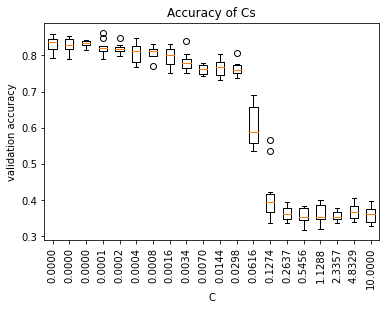

In [340]:
#visualize optimal C
from matplotlib import pyplot as plt
%matplotlib inline

plt.boxplot(accs)
plt.xticks(range(1,len(costs)+1),['%.4f'%(c) for c in costs],rotation='vertical')
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.title('Accuracy of Cs')
plt.show()

### Results
Through many trials, we determined that the BFGS Quasi-Newton Method was the most effective optimization for our data set. BFGS and Steepst Descent had similar accuracies, but BFGS was more time efficient, and it is adaptive, giving it the edge. While SGD is far less computational, it requires many iterations to get an accuracy close to BFGS. None of us are big statisticians, but we determined the L2 regularization was most beneficial because it is most useful when the data set has codependent features. This is very much the case for our data set since all ratings rely on the descriptors to classify them, some only requiring one or two of those descriptors to classify them as T vs ET or T vs M. The most optimal C was determined by exhaustively searching with BFGS and L2 normalization, and through the visualization it can be seen that a C of about .0001 is most optimal. Thus, our highest performing optimization is BFGS with L2 normalization with a C of .0001. It yields and accuracy of about 85% best case in 51.9 ms. This method of finding C, which is effectively data snooping, is unfortunately an easy way to overfit the data, since we are solely basing our optimal C on the training and test data from this data set. Any other attempted classification with other testing data used could be slightly askew because we overfit our classifier so much to this particular set of 1895 games.

### SciKit-Learn Implementation

In [14]:
%%time
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_sk = LogisticRegression(solver='liblinear',n_jobs=1, 
                           multi_class='ovr', C = 1/0.001, 
                           penalty='l2',max_iter=100) 

lr_sk.fit(X,y) # no need to add bias term, sklearn does it internally!!
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

Accuracy of:  0.8580474934036939
Wall time: 114 ms


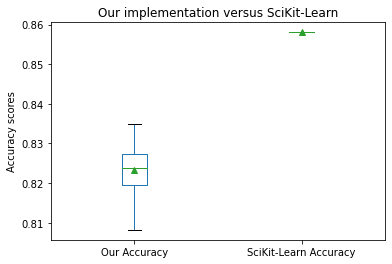

Our average time for training and prediction:  0.1000389524000002
SciKit-Learn's average time for training and prediction:  0.020801090999966618


In [41]:
import time
from numpy import mean

our_t = []
our_a = []
sci_t = []
sci_a = []

for x in range(100):
    obeg=time.perf_counter()
    ol =lr_explor(0.0001)
    oa = mean(ol)
    our_a.append(oa)
    oend=time.perf_counter()
    ot = oend-obeg
    our_t.append(ot)
    sbeg=time.perf_counter()
    lr_sk.fit(X,y)
    sp = lr_sk.predict(X)
    sa = accuracy_score(y,sp)
    sci_a.append(sa)
    send=time.perf_counter()
    st = send-sbeg
    sci_t.append(st)

data = pd.DataFrame({'Our Accuracy': our_a, 'SciKit-Learn Accuracy': sci_a})
d_g = test[['Our Accuracy','SciKit-Learn Accuracy']].plot(kind='box',showmeans=True)
plt.ylabel('Accuracy scores')
plt.title('Our implementation versus SciKit-Learn')
plt.show()

Our_time = mean(our_t)/10
print('Our average time for training and prediction: ', Our_time)
sci_time = mean(sci_t)
print('SciKit-Learn\'s average time for training and prediction: ', sci_time)



## Differences between our implementation and SciKit-Learn

From the data as presented above there are a few distinct differences. The first of these is the time differential. Averaged over 100 runs our implementation executes in about a tenth of a second whereas SciKit-Learn gets around two hundreths of a second, meaning their implementation runs around five times faster than ours. The next difference is the accuracy. Our implementation averages around 82.5% whereas SciKit-Learn averages around 86%. Additionally, our implementation has about a 3% spread throughout all the iterations, where SciKit-Learn gets pretty much the same every time. This precision can be seen in the graph above, where SciKit-Learn's box plot is basically non existent because of how close its accuracy was each iteration. Thus, while our accuracy and prediction time are decent, SciKit-Learn's implementation really shows us up with its impressive execution time, better accuracy, and higher precision.

# Deployment

We would recommend utilizing the SciKit-Learn implementation for a deployed machine learning model. This comes down to two main factors being accuracy and precision. In both of these measures SciKit-Learn beats our implementation as was spoken about in the last section. While SciKit-Learn's implementation does execute faster than our implementation, our prediction problem does not really require a fast execution time since it will be mainly for offline analysis. Thus, it does not really matter SciKit-Learn is better in time performance. However, it does outperform our implementation in terms of accuracy by three to four percent. Additionally, it is incredibly precise each iteration, which is more optimal than our more varied results. Now it is not really a fair fight because SciKit-Learn has liblinear, but we can safely say that after comparing results SciKit-Learn is the optimal choice for deployment in this prediction problem. However, if the game developers do not really care about a few percentage points in accuracy, our implementation is a safe alternative.